In [1]:
import numpy as np
import cv2
from collections import defaultdict
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, QuantumCircuit
from qiskit import Aer, execute
import os

In [2]:
def generate_table(img):
    w, h = img.shape

    # Calculate the frequency of each pixel
    freq = defaultdict(int)
    for i in range(w):
        for j in range(h):
            freq[img[i][j]] += 1

    # Generate a table with all the possible values 0 to 255 in binary
    def gen_table():
        table = []
        for i in range(256):
            table.append(bin(i)[2:].zfill(8))
        return table

    # Sort the table by the number of 1's
    def sort_table(table):
        for i in range(len(table)):
            for j in range(len(table)):
                if table[i].count('1') < table[j].count('1'):
                    table[i], table[j] = table[j], table[i]
        return table

    table = gen_table()
    table = sort_table(table)
    table = table[::-1]
    
    hast_table = {}

    ordered_keys = sorted(freq, key=freq.get, reverse=True)

    for i in range(len(ordered_keys)):
        hast_table[ordered_keys[i]] = table.pop()

    for item in range(256):
        if item not in hast_table.keys():
            hast_table[item] = table.pop()

    return hast_table, [int(x) for x in list(freq.keys())]

def agrupar_pixeles(image, div = 10):
    image_agrupada = np.round(image / div).astype(int)
    image_agrupada *= div
    
    return image_agrupada



In [3]:
def process(image_original, show_model = False):
    image = image_original.copy() # agrupar_pixeles(image_original, 5)

    # Initialize the quantum circuit for the image 
    # Pixel position
    idx = QuantumRegister(6, 'idx')

    # grayscale pixel intensity values
    intensity = QuantumRegister(8,'intensity')

    # create the quantum circuit for the image
    qc_image = QuantumCircuit(intensity, idx)

    num_qubits = qc_image.num_qubits

    for idx_ in range(intensity.size):
        qc_image.i(idx_)

    for idx_ in range(idx.size):
        qc_image.h(idx_ + intensity.size)

    qc_image.barrier()

    image_ = image.reshape(-1)

    hast_table, _ = generate_table(image)

    for i, value in enumerate(image_):
        # Convert the value to binary string
        i_ = format(i, '06b')
        value_ = hast_table[value]
        if value_ == '00000000': continue
        for idx, px_value in enumerate(i_[::-1]):
            if(px_value=='1'):
                qc_image.x(num_qubits-(idx+1))
        for idx, px_value in enumerate(value_[::]):
            if(px_value=='1'):
                qc_image.mcx([num_qubits-1, num_qubits-2, num_qubits-3, num_qubits-4, num_qubits-5, num_qubits-6], num_qubits-(idx+7))
        for idx, px_value in enumerate(i_[::-1]):
            if(px_value=='1'):
                qc_image.x(num_qubits-(idx+1))
        qc_image.barrier()

    qc_image.measure_all()

    backend = Aer.get_backend('aer_simulator')
    job = execute(qc_image, backend)
    result = job.result()

    counts = result.get_counts(qc_image)
    list_counts = list(counts.keys())

    hast_table = {v: k for k, v in hast_table.items()}

    # Create a new image from the results of the quantum circuit
    new_image = np.zeros((64))
    for value in list_counts:
        # Get the pixel position
        idx = int(value[0:6][::-1], 2)
        # Get the pixel value
        intensity = hast_table[value[6:]]
        # Set the pixel value
        new_image[idx] = intensity

    # Reshape the image
    new_image = new_image.reshape((8, 8))

    # Flip the image in x axis and in y axis
    new_image = np.flip(new_image, axis=0)
    new_image = np.flip(new_image, axis=1)

    error = np.sum(abs(image_original - new_image))
    
    # Show the original and the new image in same plot with title (and the error between them)
    plt.subplot(1, 3, 1)
    plt.title('Original image')
    plt.imshow(image_original, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title('New image')
    plt.imshow(new_image, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title('Error: {}'.format(error))
    plt.imshow(abs(image_original - new_image), cmap='gray')
    plt.show()

    #print(list(counts.keys()))
    print('Depth: {}'.format(qc_image.depth()))

    if show_model:
        return qc_image.draw(output='mpl')

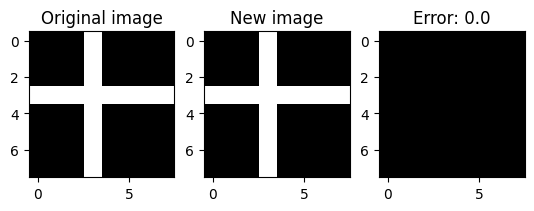

Depth: 47


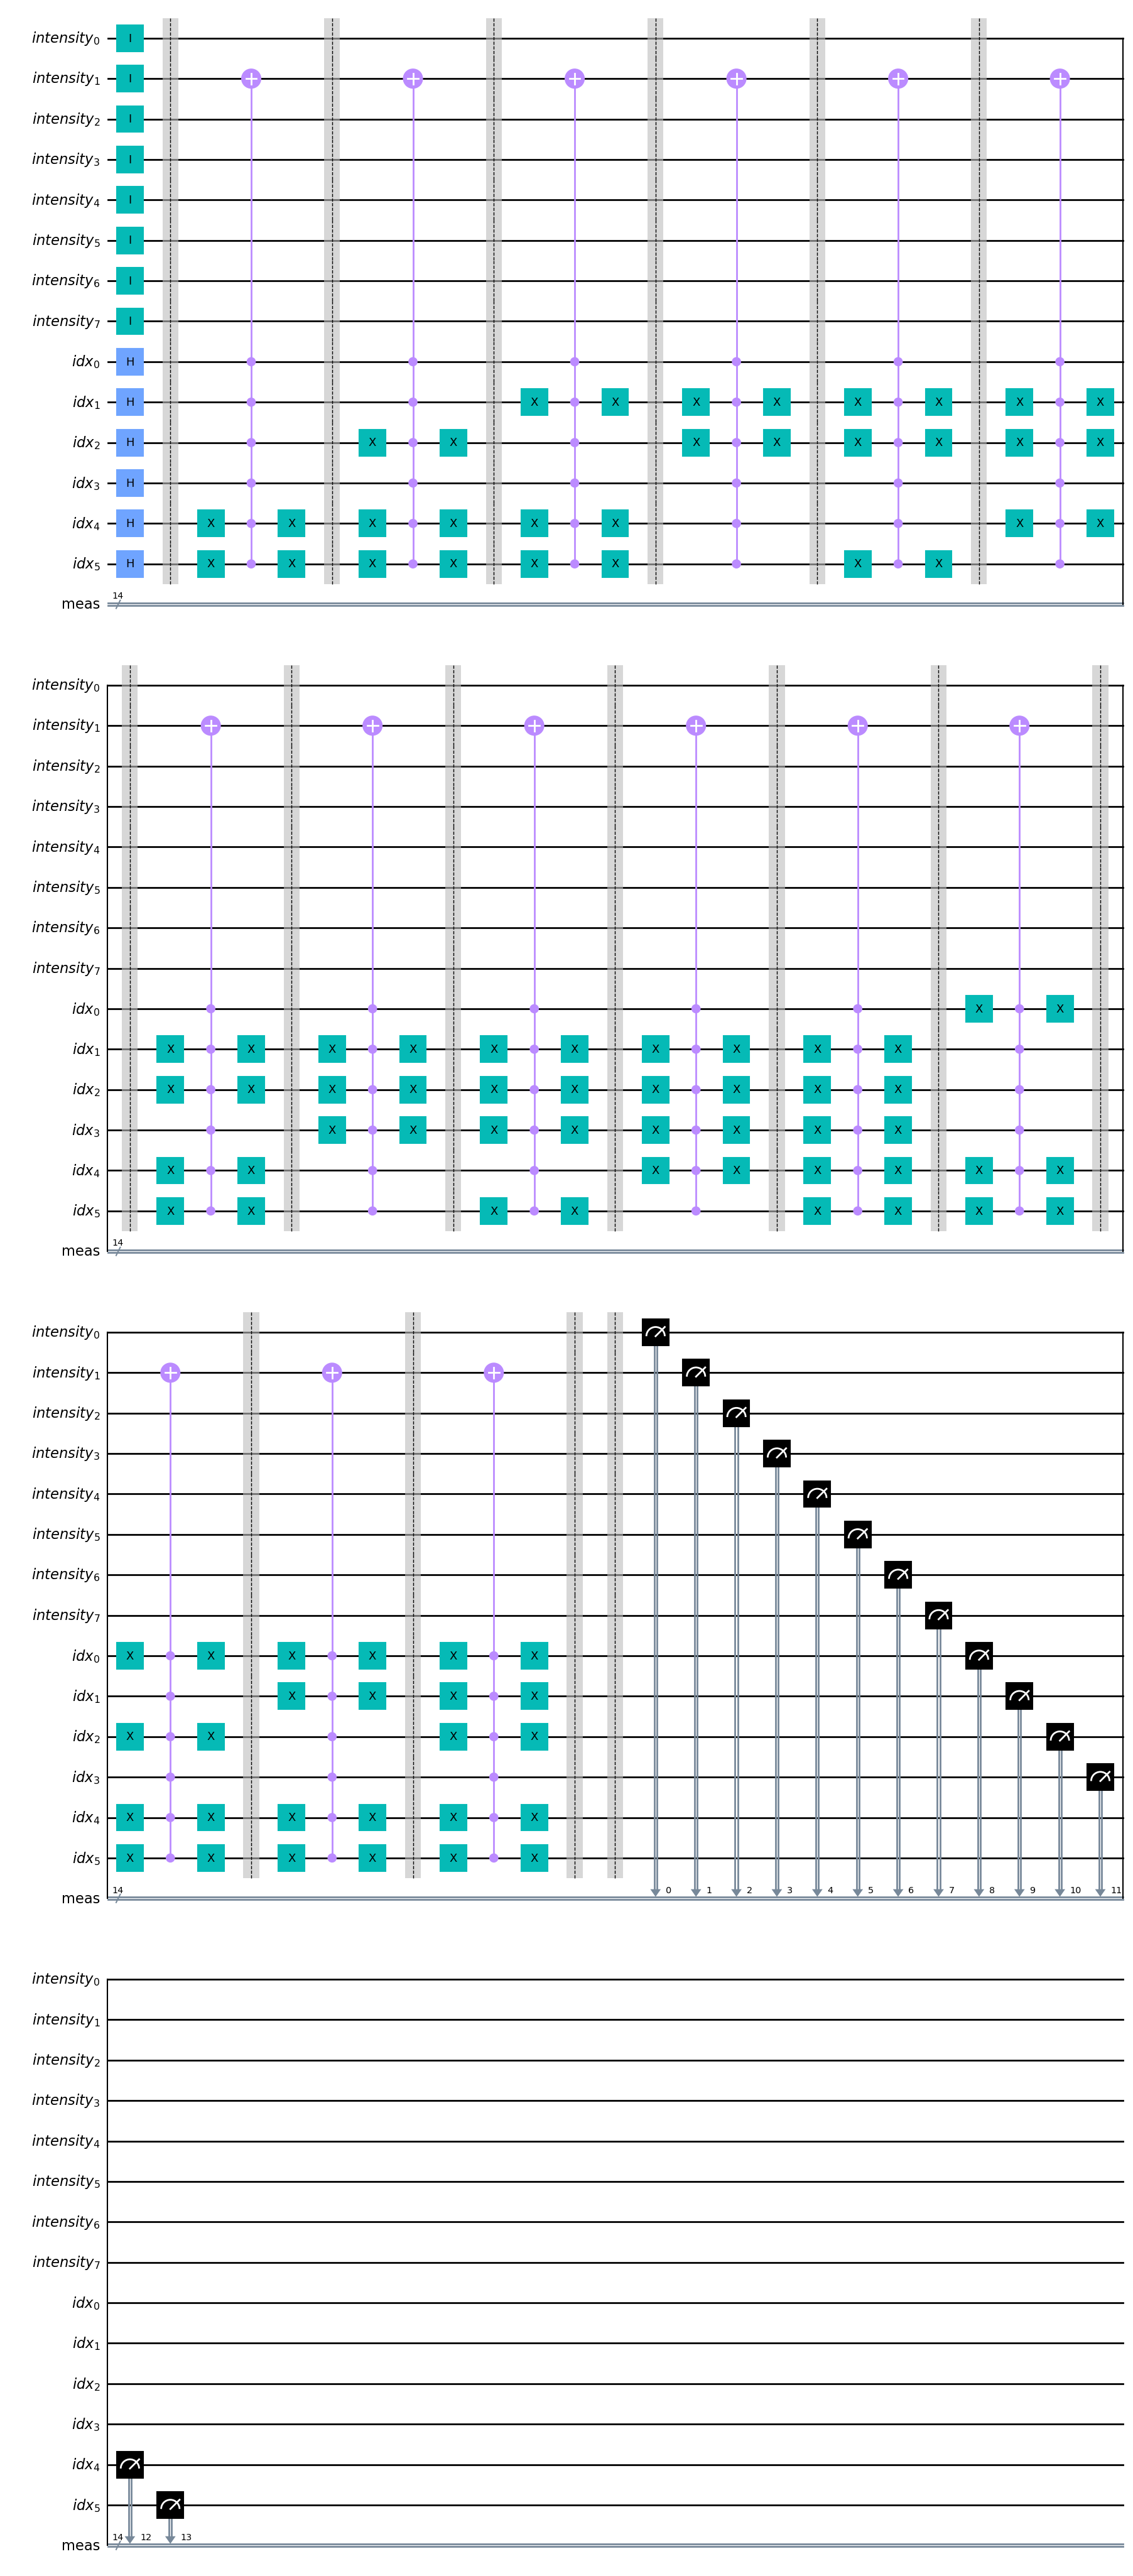

In [4]:
# Read images from folder images
images =  [cv2.imread(os.path.join('./../dataset', file), 0) for file in os.listdir('./../dataset')]

process(images[0], True)

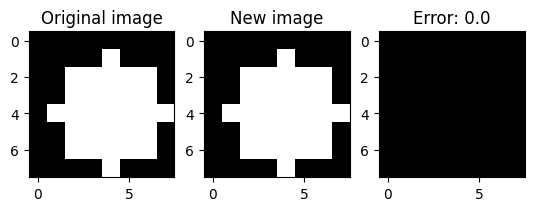

Depth: 89


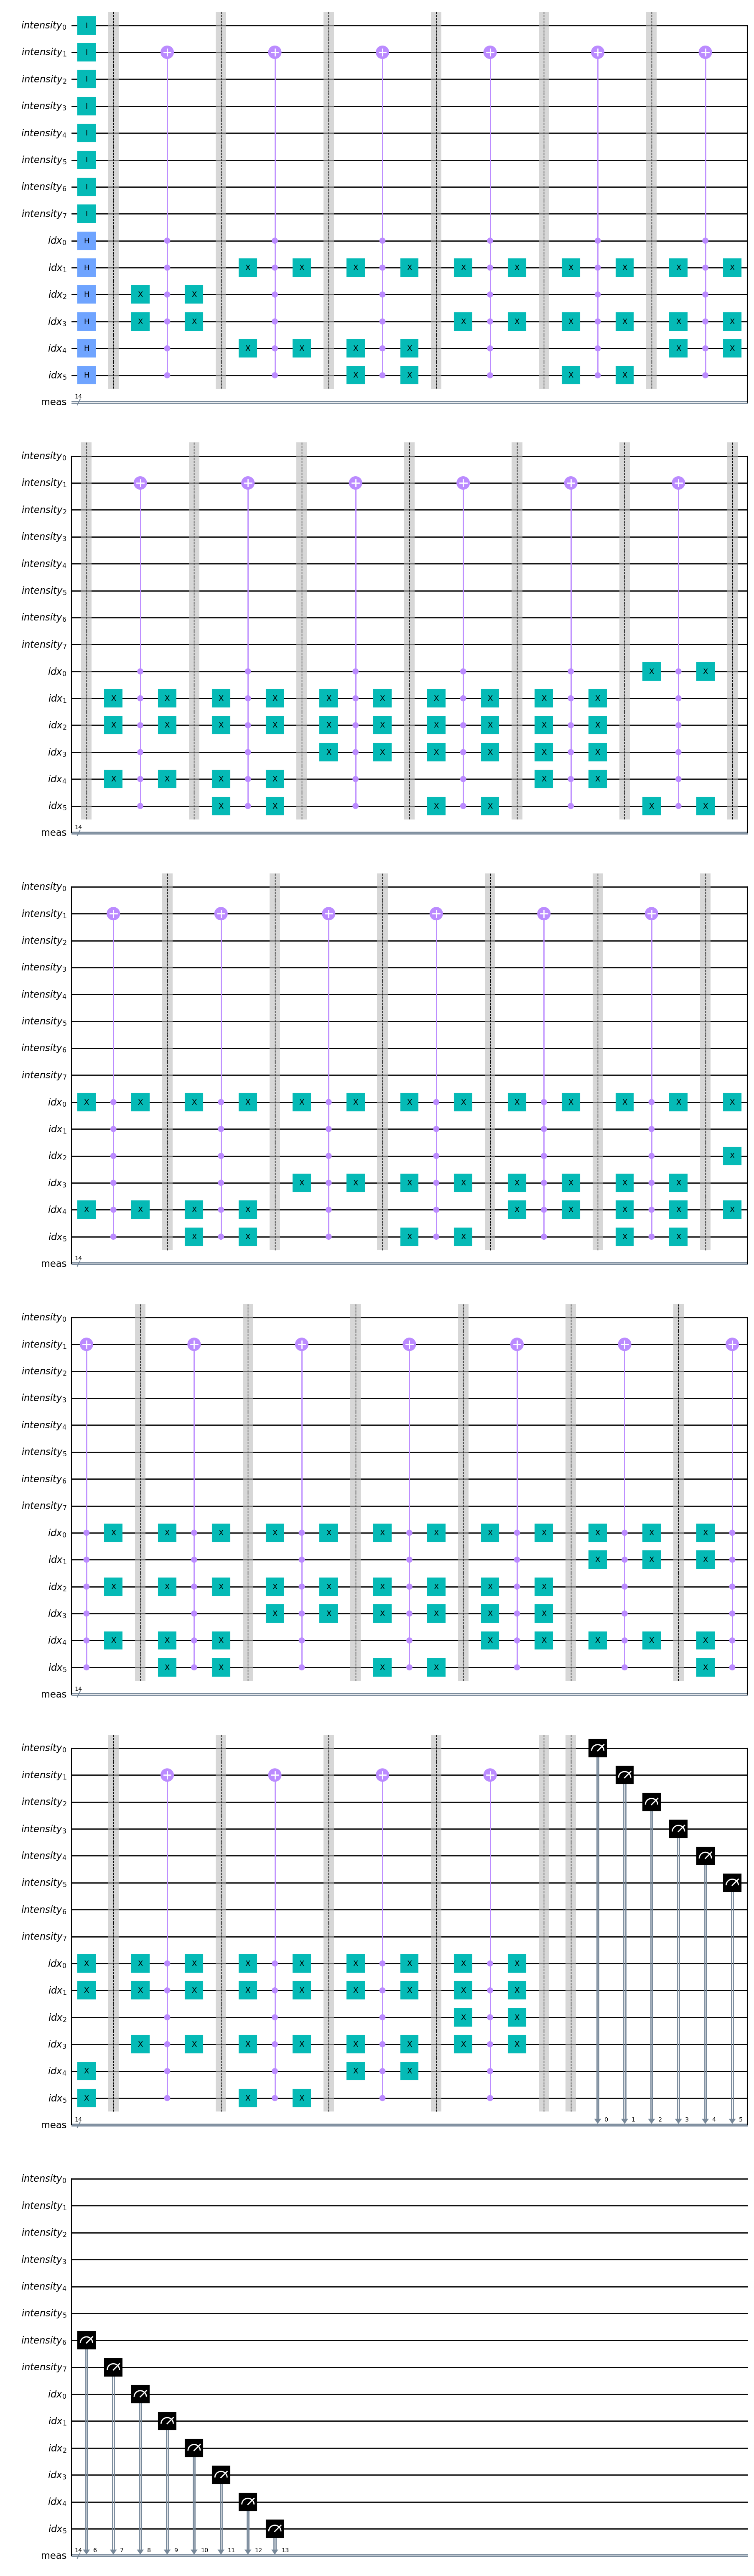

In [5]:
process(images[1], True)

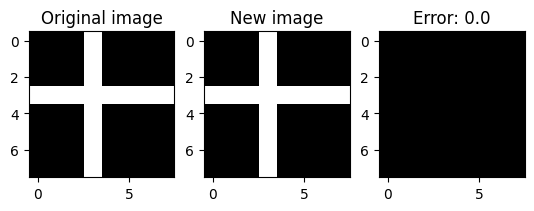

Depth: 47


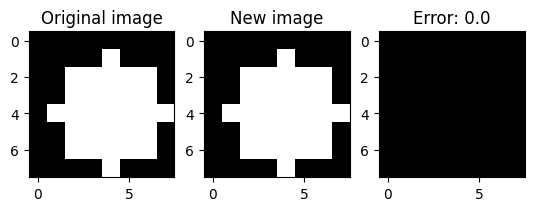

Depth: 89


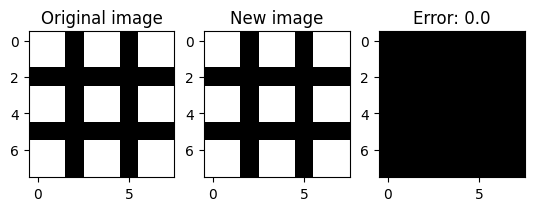

Depth: 86


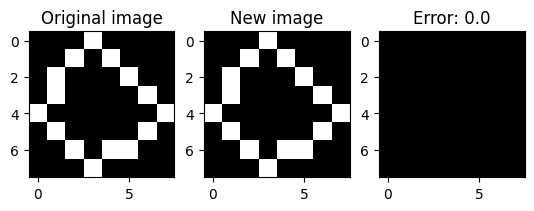

Depth: 47


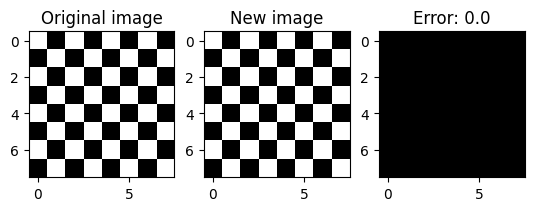

Depth: 98


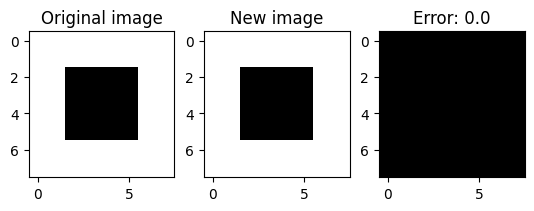

Depth: 50


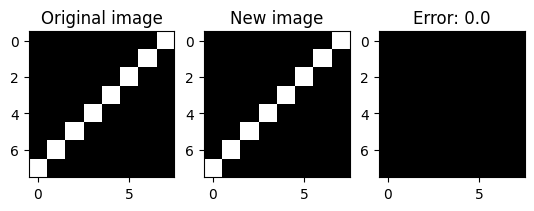

Depth: 26


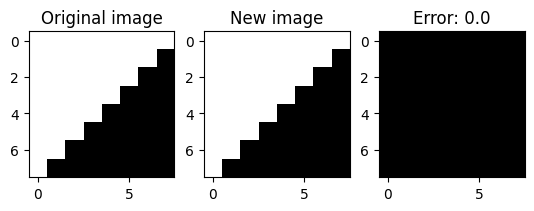

Depth: 86


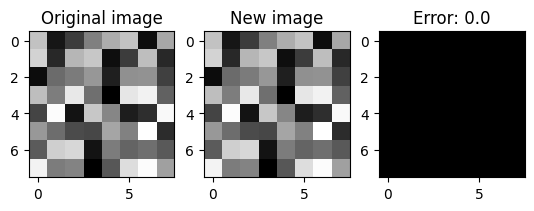

Depth: 252


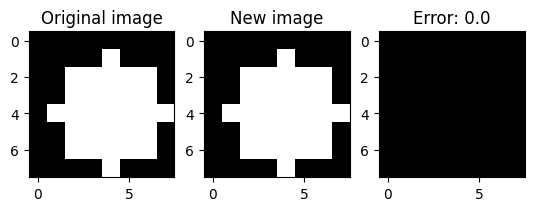

Depth: 89


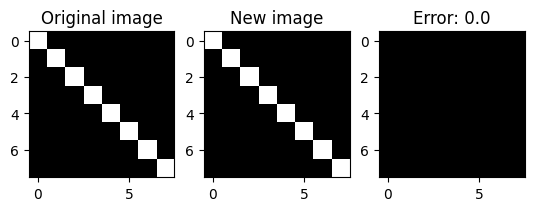

Depth: 24


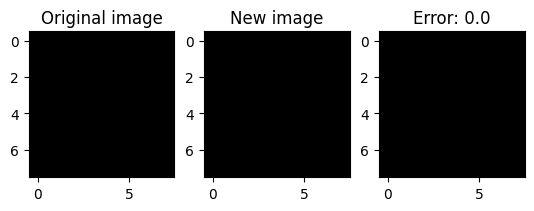

Depth: 2


In [6]:
for image in images:
    process(image)